In [1]:
# tested with pytorch==1.0, python==3.7
import os
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data
from tqdm import tqdm_notebook as tqdm
import numpy as np


IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 5000  # Size of the validation set.
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64
NUM_EPOCHS = 10
EVAL_BATCH_SIZE = 64
EVAL_FREQUENCY = 100  # Number of steps between evaluations.


# required to be cosistent with the paper (which implies consistency with the TF implementation)
def truncated_normal_(tensor, mean=0, std=1):
    """Quite inefficient implementation of truncated_normal_, but is a strict one."""
    result = torch.randn(tensor.shape)
    invalid = (result > 2) | (result < -2)
    while invalid.max() > 0:
        result = torch.where(invalid, torch.randn(tensor.shape), result)
        invalid = (result > 2) | (result < -2)
    tensor.data.copy_(result)
    tensor.data.mul_(std).add_(mean)

In [2]:
traindata = datasets.MNIST(
    os.path.expanduser('~/Data/Torch'),
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: t - 0.5)
    ]),
)
# testdata = datasets.MNIST(
#     os.path.expanduser('~/Data/Torch'),
#     train=False,
#     download=True,
#     transform=transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Lambda(lambda t: t - 0.5)
#     ]),
# )
validdata, traindata = torch.utils.data.random_split(traindata, (VALIDATION_SIZE, len(traindata) - VALIDATION_SIZE))

In [3]:
class DoubleLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.weight1 = nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight2 = nn.Parameter(torch.Tensor(out_features, out_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        
        truncated_normal_(self.weight1, std=0.1)
        truncated_normal_(self.weight2, std=0.1)
        self.bias.data.fill_(0.1)

    def forward(self, input):
        return input @ self.weight1 @ self.weight2 + self.bias


class CNN(nn.Module):

    def __init__(self, overparam):
        """
        Args:
            overparam: 'original' or 'stacked' or 'product'
        """
        super().__init__()
        
        conv1 = nn.Conv2d(NUM_CHANNELS, 32, 5, 1, 2)
        truncated_normal_(conv1.weight, std=0.1)
        conv1.bias.data.zero_()

        conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        truncated_normal_(conv1.weight, std=0.1)
        conv1.bias.data.fill_(0.1)

        self.cnn = nn.Sequential(
            conv1,
            nn.ReLU(),
            nn.MaxPool2d(2),
            conv2,
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        if overparam == 'original':
            linear1 = nn.Linear(3136, 512)
            truncated_normal_(linear1.weight, std=0.1)
            linear1.bias.data.fill_(0.1)
            linear2 = nn.Linear(512, 10)
            truncated_normal_(linear2.weight, std=0.1)
            linear2.bias.data.fill_(0.1)
        elif overparam == 'stacked':
            linear1 = nn.Linear(3136, 512)
            truncated_normal_(linear1.weight, std=0.1)
            linear1.bias.data.fill_(0.1)
            linear2 = nn.Linear(512, 10)
            truncated_normal_(linear2.weight, std=0.1)
            linear2.bias.data.fill_(0.1)
            linear1_ = nn.Linear(512, 512)
            truncated_normal_(linear1_.weight, std=0.1)
            linear1_.bias.data.fill_(0.1)
            linear2_ = nn.Linear(10, 10)
            truncated_normal_(linear2_.weight, std=0.1)
            linear2_.bias.data.fill_(0.1)
            linear1 = nn.Sequential(linear1, linear1_)
            linear2 = nn.Sequential(linear2, linear2_)
        elif overparam == 'product':
            linear1 = DoubleLinear(3136, 512)
            linear2 = DoubleLinear(512, 10)

        self.ffn = nn.Sequential(
            linear1,
            nn.ReLU(),
            nn.Dropout(0.5),
            linear2,
        )
        
    def forward(self, batch):
        cnn_out = self.cnn(batch).reshape(batch.size(0), -1)
        return self.ffn(cnn_out)

# No weight decay

In [6]:
def optimize(model, epochs):
    trainloader = torch.utils.data.DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
    log = []
    for epoch in tqdm(range(epochs)):
        scheduler.step()
        for batch_idx, (data, target) in enumerate(trainloader):
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            log.append(loss.item())
            loss.backward()
            optimizer.step()
    return np.asarray(log)

result = {case: optimize(CNN(case), 5) for case in ('original', 'stacked', 'product')}

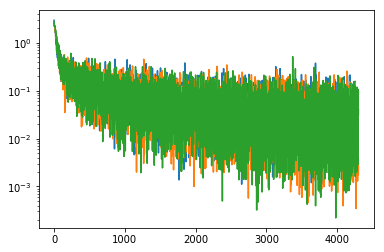

In [7]:
for label, loss in result.items():
    plt.plot(loss, label=label)
plt.yscale("log", nonposy='clip')

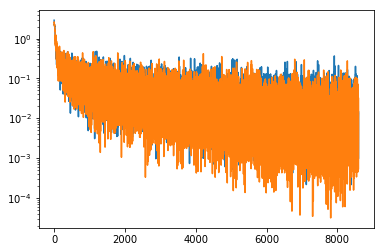

In [36]:
# do not remove me

# Weight decay

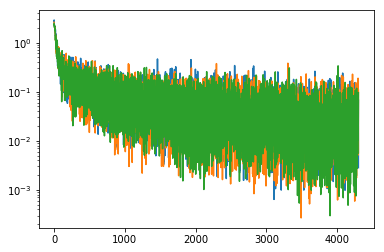

In [9]:
def optimize(model, epochs):
    trainloader = torch.utils.data.DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True)
    model.train()
    optimizer = optim.SGD(
        [{'params': model.cnn.parameters()},
         {'params': model.ffn.parameters(), 'weight_decay': 5e-4}],
        lr=0.01,
        momentum=0.9
    )
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
    log = []
    for epoch in tqdm(range(epochs)):
        scheduler.step()
        for batch_idx, (data, target) in enumerate(trainloader):
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            log.append(loss.item())
            loss.backward()
            optimizer.step()
    return np.asarray(log)

result_wd = {case: optimize(CNN(case), 5) for case in ('original', 'stacked', 'product')}
for label, loss in result_wd.items():
    plt.plot(loss, label=label)
plt.yscale("log", nonposy='clip')

# TF 

In [17]:
import pickle
with open('losses.p', 'rb') as f:
    tf_loss = pickle.load(f)
with open('losses_op.p', 'rb') as f:
    tf_loss_op = pickle.load(f)
with open('losses_op_no_reg.p', 'rb') as f:
    tf_loss_op_nr = pickle.load(f)

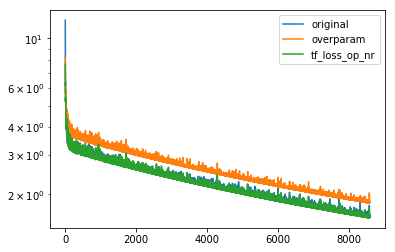

In [18]:
plt.plot(tf_loss, label='original')
plt.plot(tf_loss_op, label='overparam')
plt.plot(tf_loss_op_nr, label='tf_loss_op_nr')
plt.yscale("log", nonposy='clip')
plt.legend()